# Training Notebook

    - Part I: Baseline spatial PilotNet (Baseline vs MaxPool vs Inception)
    - Part II: FlowNet
    - Part III: Two-streams Regression Network

In [1]:
import random
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
plt.style.use('ggplot')

## Loading Training Data

In [2]:
def get_optical_flow(frame1, frame2):
    '''Frame1: previous frame
       Frame2: last frame
       Returns: Polar optical flow in RBG'''
    
    prev = cv2.cvtColor(frame1, cv2.COLOR_RGB2GRAY)
    hsv = np.zeros_like(frame1)
    hsv[...,1] = 255

    # Get present frame
    next_ = cv2.cvtColor(frame2, cv2.COLOR_RGB2GRAY)

    flow = cv2.calcOpticalFlowFarneback(prev, next_, None, 0.5, 3, 15, 3, 5, 1.2, 0)

    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])

    hsv[...,0] = ang*180/np.pi/2

    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)

    return cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)


def process_line(filename):
    '''Process one line of the batch directory.------------------------
     Read a list of two filenames: previous - current.
     Returns the optical flow !!
    '''
    frame1 = np.array(cv2.imread(filename[0])) # previous
    frame2 = np.array(cv2.imread(filename[1])) # present
    flow = get_optical_flow(frame1, frame2) # flow present vs previous 
    
    return frame1, flow  


def get_index(X, Y, offset=1):
    new_X = []
    new_Y = []
    for i in range(int(X.shape[0]-offset)):
        pair_X = [X[i], X[i + offset]]
        new_X.append(pair_X)
        new_Y.append(Y[i + offset])
        
    return np.array(new_X), np.array(new_Y)


def normalize_target(target):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(target.reshape(-1,1))
    return scaler.transform(target.reshape(-1,1)) 


def shuffle_data(X, Y, proportion = 1):
    # Generate a random selection of indexes
    indexes = random.sample(range(0, X.shape[0]), int(X.shape[0]*proportion))
    # Select desired examples
    shuffle_X = X[indexes]
    shuffle_Y = Y[indexes].astype('float32') # Already normalized
    return shuffle_X, shuffle_Y, indexes
    

def load_train_data(shuffle_X, shuffle_Y):
    images = []
    flows = []
    for element in tqdm(shuffle_X):
        current, flow = process_line(element)
        images.append(flow)
        flows.append(current)
    images = np.array(images)
    flows = np.array(flows)
    return images.reshape(-1,160,320,3), flows.reshape(-1,160,320,3)


def train_val_split(images, targets, test_proportion=0.3):
    max_index = 75000#int(images.shape[0]*(proportion-1))
    train_X = images[:max_index]
    train_Y = targets[:max_index]
    val_X = images[max_index:89000]
    val_Y = targets[max_index:89000]
    test_X = images[89000:]
    test_Y = targets[89000:]

    return train_X, train_Y, val_X, val_Y, test_X, test_Y


def train_convnet2D(model, train_X, train_Y, val_X, val_Y,
                  epochs= 100, model_name='model_checkpoint.hdf', 
                  patience=5, min_delta =0.0005, batch_size=100):

    #checkpoint to save model after each epoch
    snapshot = keras.callbacks.ModelCheckpoint(model_name, 
                                                monitor='val_loss', 
                                                verbose=1, 
                                                save_best_only=True, 
                                                mode='min')
    # Learning rate scheduler
    reduce_LR  = ReduceLROnPlateau(monitor='val_loss',factor=0.5,
                                   patience=3,verbose=True)
    
    #stop training if the validation error stops improving.
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                               min_delta=min_delta, 
                                               patience=patience, 
                                               verbose=1, 
                                               mode='auto')
    # Training step
    history = model.fit(train_X, train_Y, 
                     shuffle=True, epochs=epochs,
                     validation_data = ([val_X, val_Y]),
                     callbacks = [early_stop, reduce_LR, snapshot],
                     batch_size=batch_size
                    )    

    return model, history

# Define functions for two streams networks

def train_two_streams(model, train_list, train_Y, val_list, val_Y,
                  epochs= 100, model_name='2streams_checkpoint.hdf', 
                  patience=5, min_delta =0.0005, batch_size=100):

    #checkpoint to save model after each epoch
    snapshot = keras.callbacks.ModelCheckpoint(model_name, 
                                                monitor='val_loss', 
                                                verbose=1, 
                                                save_best_only=True, 
                                                mode='min')
    # Learning rate scheduler
    reduce_LR  = ReduceLROnPlateau(monitor='val_loss',factor=0.5,
                                   patience=3,verbose=True)
    
    #stop training if the validation error stops improving.
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                               min_delta=min_delta, 
                                               patience=patience, 
                                               verbose=1, 
                                               mode='auto')
    # Training step
    history = model.fit(train_list, train_Y, 
                     shuffle=True, epochs=epochs,
                     validation_data = (val_list, val_Y),
                     callbacks = [early_stop, reduce_LR, snapshot],
                     batch_size=batch_size
                    )    

    return model, history


def plot_train_loss(history):
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Training loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    
def norm(x):
    return (x/255) - 0,5



## Studied Architectures (Using Functional API)
    - Baseline Dropout 0.5. Before or after flatten?
    - InceptionV3

In [3]:
import keras
from keras.layers import *
from keras.optimizers import*
from keras.models import Model, load_model
from keras.callbacks import *

def baseline(input_shape=(160,320,3), dropout=0.5):
    """
   Classic NVIDIA model.
    """
    inputs = Input(input_shape)
    
    x = Lambda(lambda x: x/127.5-1.0, input_shape=input_shape)(inputs)
    
    x = Conv2D(24, (5, 5), activation='elu', strides=(2, 2))(x)

    x = Conv2D(36, (5, 5), activation='elu', strides=(2, 2))(x)

    x = Conv2D(48, (5, 5), activation='elu', strides=(2, 2))(x)

    x = Conv2D(64, (3, 3), activation='elu')(x)

    x = Conv2D(64, (3, 3), activation='elu')(x)
    
    x = Dropout(dropout)(x)
    
    x = Flatten()(x)
    
    x = Dense(100, activation='elu')(x)
    x = Dense(50, activation='elu')(x)
    x = Dense(10, activation='elu')(x)
    x = Dense(1)(x)
    
    model = Model(inputs, x)
    #sgd = SGD(lr=1e-4)
    #model.compile(optimizer='SGD', momentum=0.9, 
    #              weight_decay=1e-7, loss='mse')

    adam = Adam(lr=1e-4)
    model.compile(optimizer=adam, loss='mse')
    #model.summary()

    return model


def pooling_model(input_shape=(160,320,3), dropout=0.5):
    
    inputs = Input(input_shape)
    x = Lambda(lambda x: x / 127.5 - 1., input_shape=(40, 40, 1))(inputs)

    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), padding='valid')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), padding='valid')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), padding='valid')(x)

    x = Flatten()(x)
    x = Dropout(0.5)(x)

    x = Dense(128)(x)

    x = Dense(64)(x)
    x = Dense(1)(x)
    
    model = Model(inputs, x)
    adam = Adam(lr=1e-4)
    model.compile(optimizer=adam, loss='mse')    
    #model.compile(optimizer=Adam(lr=0.0001), loss='mse')
        
    return model


def inceptionV3(input_shape=(160,320,3), imagenet=False):
    '''Only Train for a few epochs to adjust output layer!'''
    from keras.applications.inception_v3 import InceptionV3
    from keras.preprocessing import image
    from keras.models import Model
    from keras.layers import Dense, GlobalAveragePooling2D
    from keras import backend as K

    # create the base pre-trained model
    if imagenet:
        base_model = InceptionV3(weights='imagenet', include_top=False,
                                input_shape=input_shape)
    else:
        base_model = InceptionV3(weights=None, include_top=False,
                                input_shape=input_shape)    

    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dense(1024, activation='relu')(x)
    # and a logistic layer -- let's say we have 200 classes
    predictions = Dense(1, activation='linear')(x)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)

    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    for layer in base_model.layers:
        layer.trainable = False

    # compile the model (should be done *after* setting layers to non-trainable)
    adam = Adam(lr=1e-4)
    model.compile(optimizer=adam, loss='mse')      
    #model.compile(optimizer='rmsprop', loss='mse')
    
    return model

    # train the model on the new data for a few epochs
    #model.fit_generator(...)

    
def finetune_V3(model):
    '''Now train the ConvLayers'''
    # at this point, the top layers are well trained and we can start fine-tuning
    # convolutional layers from inception V3. We will freeze the bottom N layers
    # and train the remaining top layers.

    # let's visualize layer names and layer indices to see how many layers
    # we should freeze:
    #for i, layer in enumerate(base_model.layers):
    #    print(i, layer.name)

    # we chose to train the top 2 inception blocks, i.e. we will freeze
    # the first 249 layers and unfreeze the rest:
    for layer in model.layers[:249]:
        layer.trainable = False
    for layer in model.layers[249:]:
        layer.trainable = True

    # we need to recompile the model for these modifications to take effect
    # we use SGD with a low learning rate
    model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='mse')
    
    return model


def two_streams(spatial, temporal, method_add=True):
    
    if method_add == True:
        mergedOut = Add()([spatial.output, temporal.output])
    else:
        mergedOut = Concatenate()([spatial.output, temporal.output])
    
    mergedOut = Dropout(.1)(mergedOut)

    mergedOut = Dense(100, activation='elu')(mergedOut)

    mergedOut = Dense(50, activation='elu')(mergedOut)

    mergedOut = Dense(10, activation='elu')(mergedOut)

    mergedOut = Dense(1, activation='linear')(mergedOut)
    
    return Model([spatial.input, temporal.input], mergedOut)


Using TensorFlow backend.


# Model training 

In [4]:
# Load dataset
lane1 = pd.read_csv('Dataset/2016-01-30--11-24-51/Metadata/lane_df.csv',index_col=0)

lane4 = pd.read_csv('Dataset/2016-02-02--10-16-58/Metadata/lane_df.csv',index_col=0)

lane5 = pd.read_csv('Dataset/2016-02-08--14-56-28/Metadata/lane_df.csv',index_col=0)

lane6 = pd.read_csv('Dataset/2016-02-11--21-32-47/Metadata/lane_df.csv',index_col=0)

lane7 = pd.read_csv('Dataset/2016-03-29--10-50-20/Metadata/metadata.csv',index_col=0)

X = []
Y = []
for df in [lane1, lane5, lane6, lane7]:#, lane8, lane9, lane10]:
    X.append(df['filenames'].values)
    Y.append(df['steering_angle'].values)

X = np.concatenate(X)
Y = np.concatenate(Y).astype('float32')

# Subsample at 2.5 Hz
X = X[::2]
Y = Y[::2]

print('Shape X', np.shape(X))
print('Shape Y', np.shape(Y))


Shape X (93054,)
Shape Y (93054,)


In [5]:
# Generate indexes
new_X, new_Y = get_index(X, Y, offset=1)

# Normalize targets
targets = normalize_target(new_Y)

# Shuffle indexes
shuffle_X, shuffle_Y, indexes = shuffle_data(new_X, targets)

# Load data and compute flows
images, flows = load_train_data(shuffle_X, shuffle_Y)


100%|██████████| 93053/93053 [29:09<00:00, 53.20it/s]


## Data Augmentation
    - Option 1: Using the same methodology that the Axionaut. Original Data + Augmented
    - Option 2: Modifying the images keeping the same final amount.
 
     Note: The augmentation should not alter the optical flow. To guarantee that, it is necessary to apply the augmentation in pairs image - flow.
     It should be done after shuffle the examples.
     
     - A simple option could be only augment the original images and not the flows.

### Option1: 

In [ ]:
from augmentation.py import *

augmentation = True
if augmentation:
    print('Augmenting data... Wait...')
    # Data augmentation 25% of random brightness.
    X_bright, Y_bright = generate_brightness(images, shuffle_Y, proportion=0.25)

    # Data augmentation 25% of horizontal flipping.
    X_flip, Y_flip = generate_horizontal_flip(images, shuffle_Y, proportion=0.25)
    
    # Data augmentation 25% of random shadows.
    X_shadow, Y_shadow = generate_random_shadows(images, shuffle_Y, proportion=0.25)
    
    # Data augmentation 25% of chained tranformations (bright + shadows + flip).
    X_chain, Y_chain = generate_chained_transformations(images, shuffle_Y, proportion=0.25)

    # Concatenating Axionable dataset with the transformations.
    augmented_X = np.concatenate((images, X_bright,
                                X_flip, X_shadow, X_chain))

    augmented_Y = np.concatenate((images, Y_bright, 
                                Y_flip, Y_shadow, Y_chain)).astype('float32')

In [6]:
# Train validation split
train_X1, train_Y1, val_X1, val_Y1, test_X1, test_Y1 = train_val_split(images, shuffle_Y, test_proportion=0.3)
train_X2, train_Y2, val_X2, val_Y2, test_X2, test_Y2 = train_val_split(flows, shuffle_Y, test_proportion=0.3)

del images, flows 

## Part 1A - Spatial Nvidia Baseline

In [30]:
spatial = baseline()

In [ ]:
import keras
from keras.callbacks import *

spatial_final, history = train_convnet2D(spatial, train_X, train_Y, val_X, val_Y)

Train on 75000 samples, validate on 14000 samples
Epoch 1/100
75000/75000 [==============================] - 190s 3ms/step - loss: 0.0620 - val_loss: 0.0417

Epoch 00001: val_loss improved from inf to 0.04174, saving model to model_checkpoint.hdf
Epoch 2/100
74900/75000 [============================>.] - ETA: 0s - loss: 0.0301

In [44]:
spatial_test = load_model('model_checkpoint.hdf')

In [51]:
spatial_test.evaluate(test_X, test_Y)

4053/4053 [==============================] - 4s 1ms/step


0.014246541177663219

In [55]:
preds = [spatial_test.predict(np.expand_dims(x, axis=0)) for x in test_X]

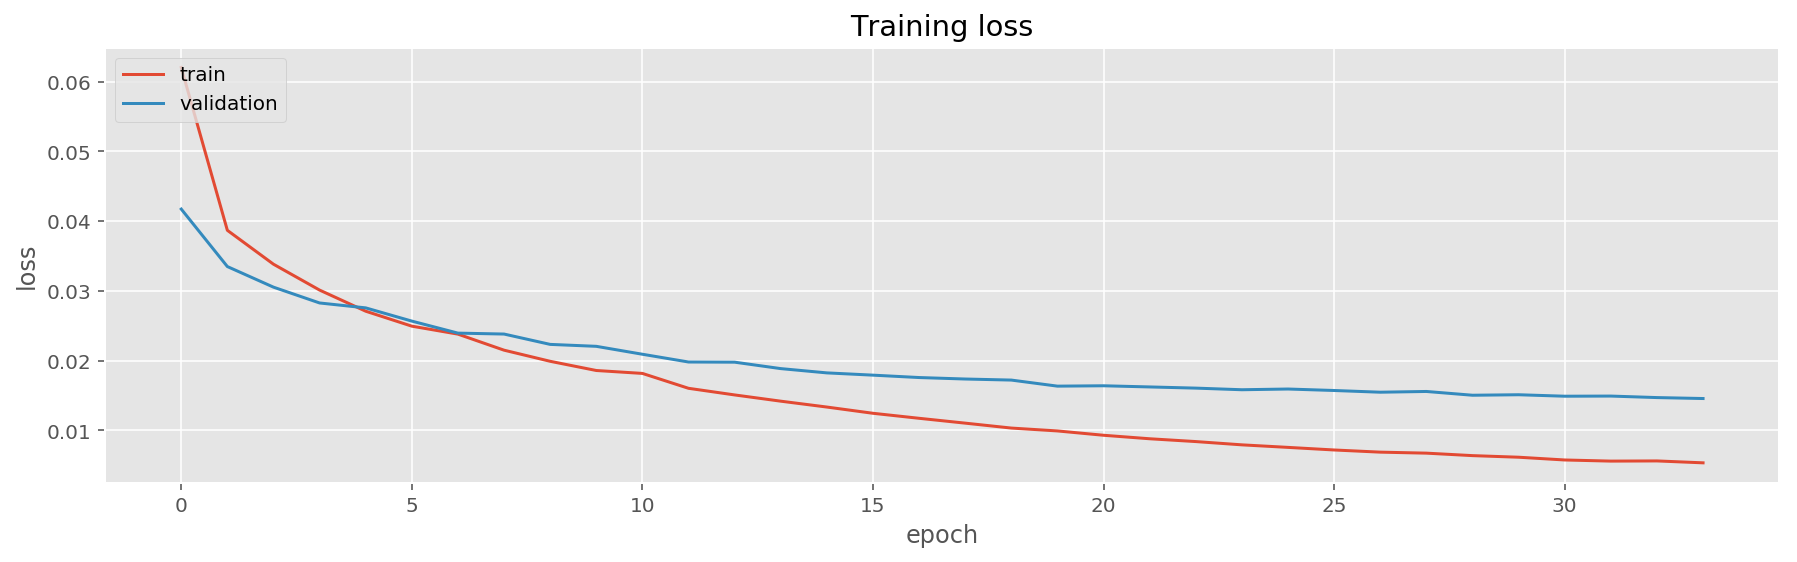

In [60]:
rcParams['figure.figsize'] = 15, 4
plot_train_loss(history)

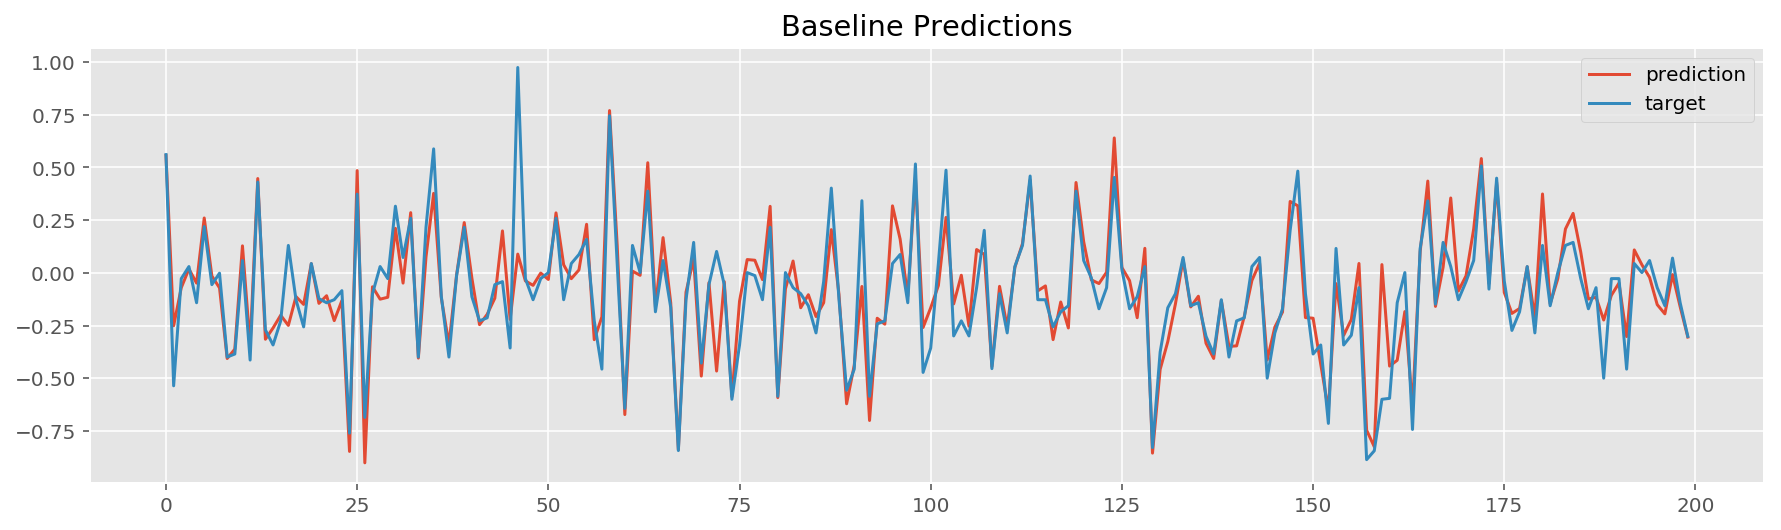

In [73]:
plt.plot(np.array(preds[:200]).reshape(-1), label='prediction')
plt.plot(test_Y[:200], label='target')
plt.title('Baseline Predictions')
plt.legend()

## Part 1B - Spatial Nvidia MaxPool

In [63]:
spatial1 = pooling_model()

In [ ]:
spatial_final1, history1 = train_convnet2D(spatial1, train_X, train_Y, val_X, val_Y, model_name='pooling_check.hdf5')

In [67]:
pooling_test = load_model('pooling_check.hdf5')

In [68]:
pooling_test.evaluate(test_X, test_Y)

4053/4053 [==============================] - 7s 2ms/step


0.023740348918788557

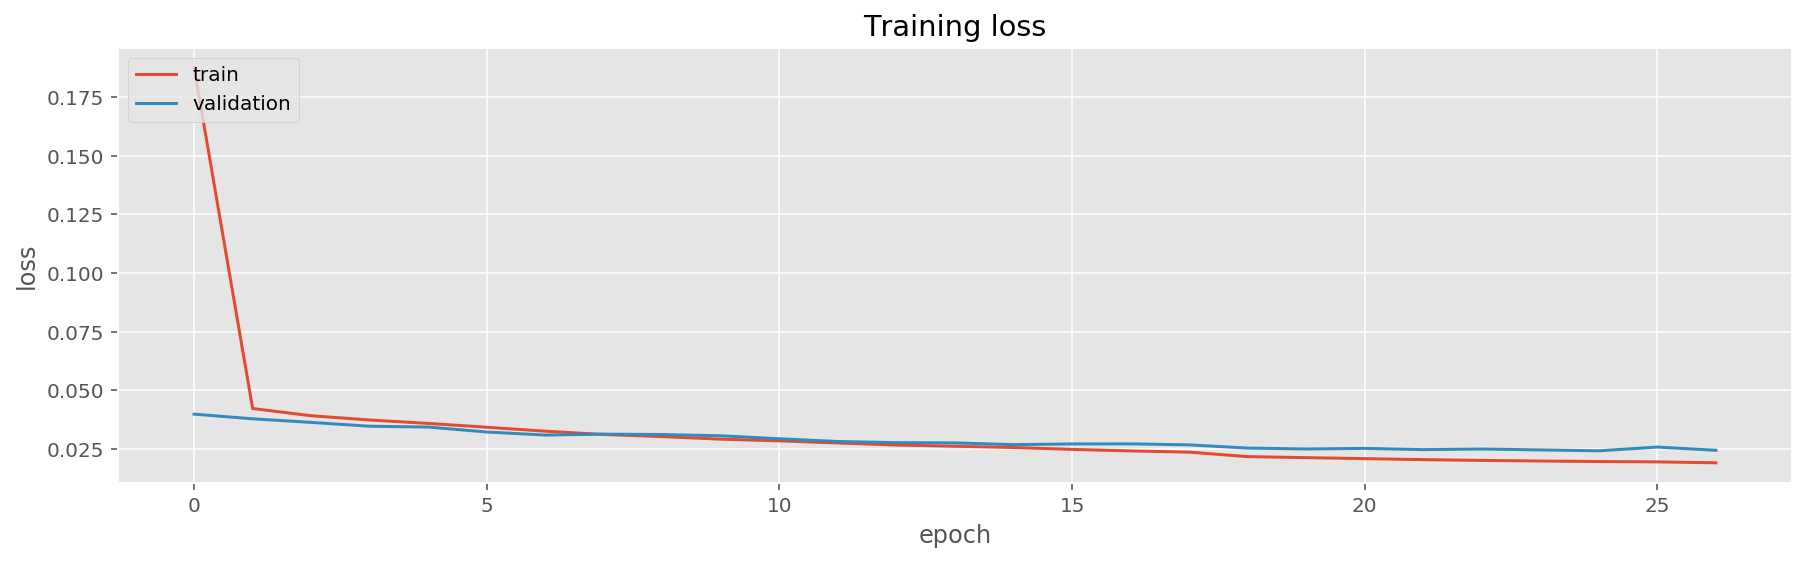

In [69]:
rcParams['figure.figsize'] = 15, 4
plot_train_loss(history1)

In [70]:
preds1 = [pooling_test.predict(np.expand_dims(x, axis=0)) for x in test_X]

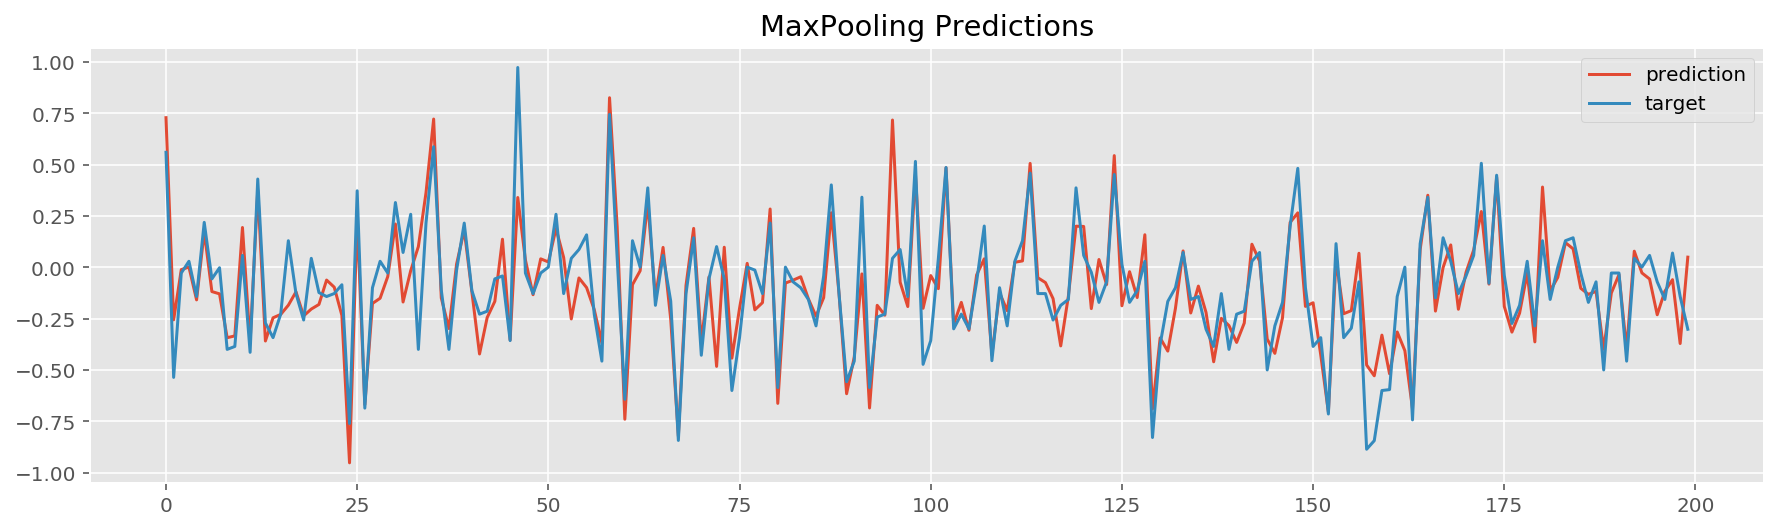

In [72]:
plt.plot(np.array(preds1[:200]).reshape(-1), label='prediction')
plt.plot(test_Y[:200], label='target')
plt.title('MaxPooling Predictions')
plt.legend()

## Part II - FlowNet


In [7]:
flow = baseline()

In [8]:
flow_final, history_flow = train_convnet2D(flow, train_X, train_Y, val_X, val_Y, model_name='flow_check.hdf5')

Train on 75000 samples, validate on 14000 samples
Epoch 1/100
75000/75000 [==============================] - 158s 2ms/step - loss: 0.1069 - val_loss: 0.0773

Epoch 00001: val_loss improved from inf to 0.07732, saving model to flow_check.hdf5
Epoch 2/100
75000/75000 [==============================] - 170s 2ms/step - loss: 0.0760 - val_loss: 0.0675

Epoch 00002: val_loss improved from 0.07732 to 0.06748, saving model to flow_check.hdf5
Epoch 3/100
75000/75000 [==============================] - 171s 2ms/step - loss: 0.0637 - val_loss: 0.0561

Epoch 00003: val_loss improved from 0.06748 to 0.05611, saving model to flow_check.hdf5
Epoch 4/100
75000/75000 [==============================] - 171s 2ms/step - loss: 0.0525 - val_loss: 0.0471

Epoch 00004: val_loss improved from 0.05611 to 0.04709, saving model to flow_check.hdf5
Epoch 5/100
75000/75000 [==============================] - 171s 2ms/step - loss: 0.0431 - val_loss: 0.0401

Epoch 00005: val_loss improved from 0.04709 to 0.04014, saving

In [11]:
flow_test = load_model('flow_check.hdf5')

In [12]:
flow_test.evaluate(test_X, test_Y)

4053/4053 [==============================] - 4s 1ms/step


0.013086546696134255

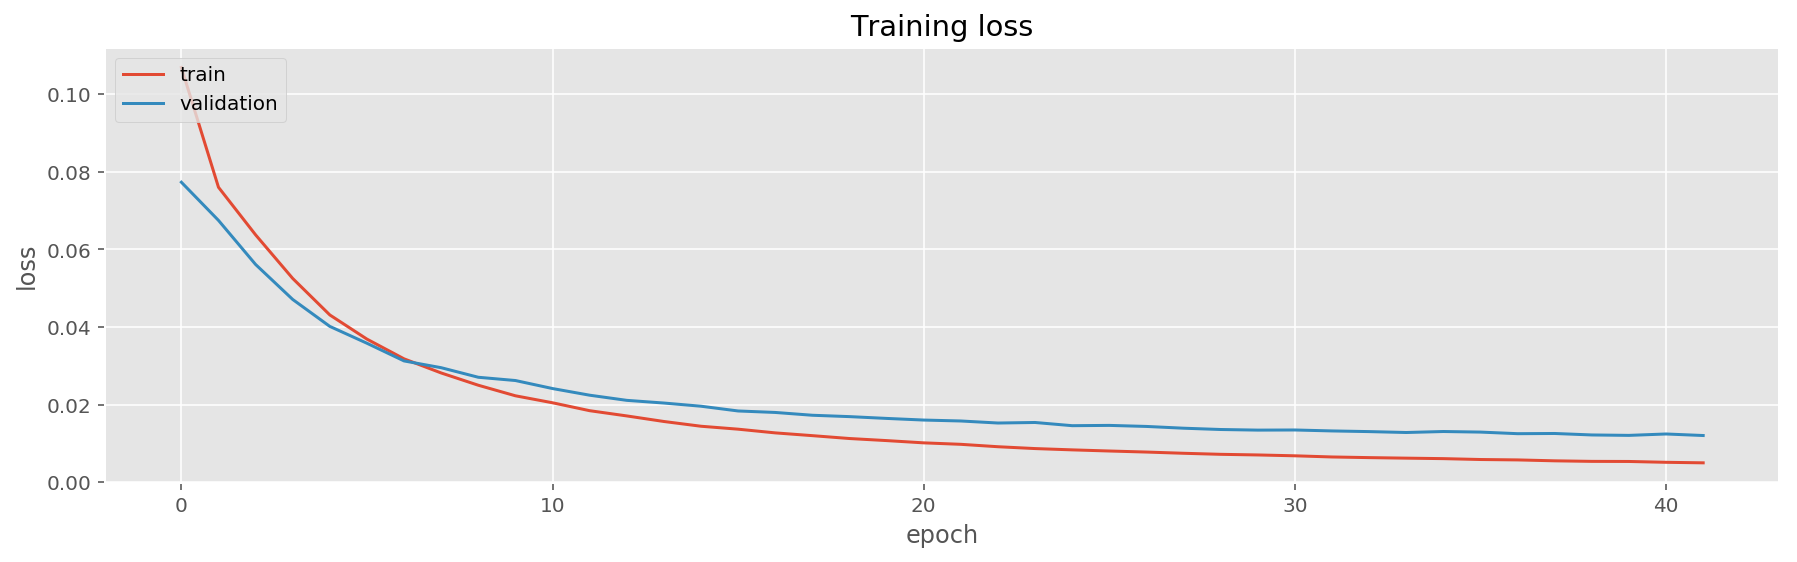

In [13]:
rcParams['figure.figsize'] = 15, 4
plot_train_loss(history_flow)

In [14]:
preds5 = [flow_test.predict(np.expand_dims(x, axis=0)) for x in test_X]

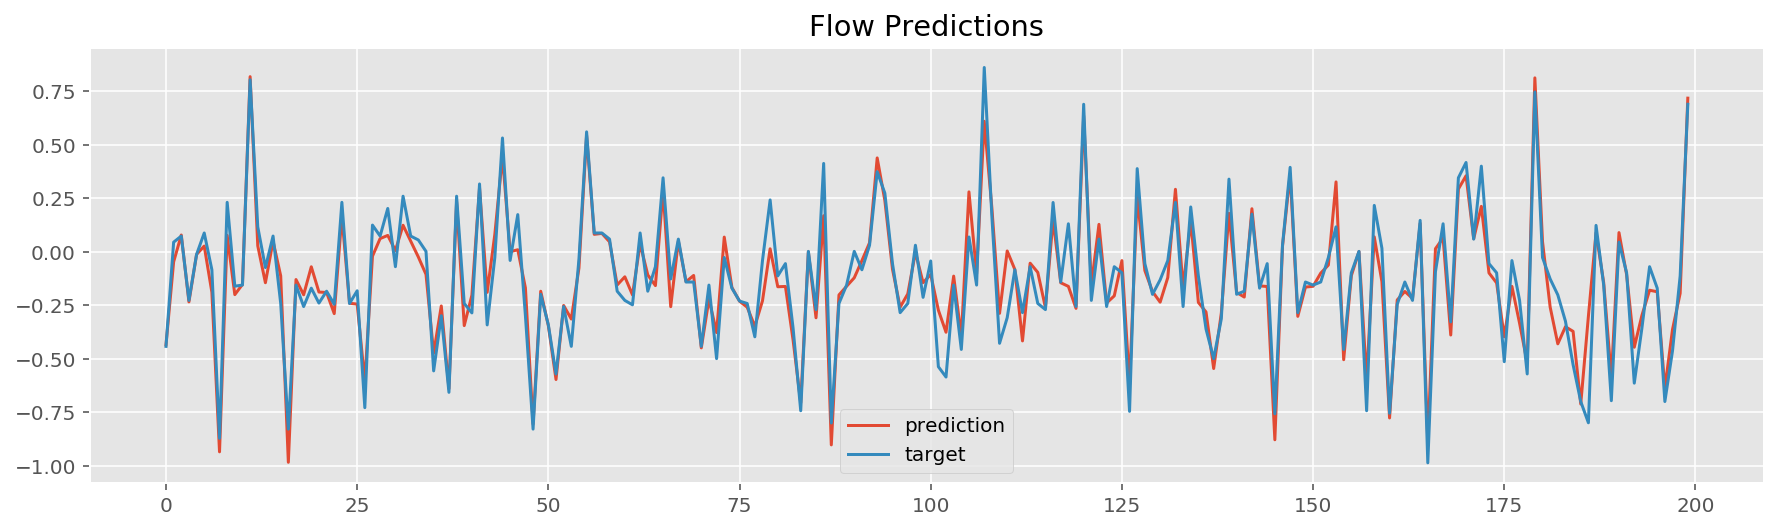

In [15]:
plt.plot(np.array(preds5[:200]).reshape(-1), label='prediction')
plt.plot(test_Y[:200], label='target')
plt.title('Flow Predictions')
plt.legend()

## Part III - Two-stream Networks
### Experience 1:
        - Fine Tuning (training all layers)
        - Not using embedings but only predictions

In [11]:
# Load spatial model with the pre-trained weights 
# It would be nice to train this network in another notebook with new & augmented data
spatial = load_model('model_checkpoint.hdf')
temporal = load_model('flow_check.hdf5')

In [33]:
# Faut il fixer les convolutional layers?
transfer_learning = False

if transfer_learning:
    for layer in spatial.layers[:5]:
        layer.trainable = False

    for layer in temporal.layers[:5]:
        layer.trainable = False

In [13]:
spatial.get_layer(name='dropout_2').name='dropout_2_2'
two_st = two_streams(spatial, temporal, method_add=True)

In [19]:
adam = Adam(lr=1e-4)
two_st.compile(optimizer=adam, loss='mse')   

In [15]:
train_list = [train_X1, train_X2]
val_list = [val_X1, val_X2]

In [24]:
test_list = [test_X1, test_X2]

In [20]:
final_2streams, history_streams = train_two_streams(two_st, train_list, train_Y1, val_list, val_Y1)

Train on 75000 samples, validate on 14000 samples
Epoch 1/100
75000/75000 [==============================] - 313s 4ms/step - loss: 0.0257 - val_loss: 0.0041

Epoch 00001: val_loss improved from inf to 0.00405, saving model to 2streams_checkpoint.hdf
Epoch 2/100
75000/75000 [==============================] - 322s 4ms/step - loss: 0.0142 - val_loss: 0.0042

Epoch 00002: val_loss did not improve from 0.00405
Epoch 3/100
75000/75000 [==============================] - 322s 4ms/step - loss: 0.0141 - val_loss: 0.0040

Epoch 00003: val_loss improved from 0.00405 to 0.00397, saving model to 2streams_checkpoint.hdf
Epoch 4/100
75000/75000 [==============================] - 322s 4ms/step - loss: 0.0133 - val_loss: 0.0037

Epoch 00004: val_loss improved from 0.00397 to 0.00374, saving model to 2streams_checkpoint.hdf
Epoch 5/100
75000/75000 [==============================] - 322s 4ms/step - loss: 0.0137 - val_loss: 0.0041

Epoch 00005: val_loss did not improve from 0.00374
Epoch 6/100
75000/75000 

In [23]:
stream_test = load_model('2streams_checkpoint.hdf')

In [25]:
flow_test.evaluate(test_list, test_Y1)

4053/4053 [==============================] - 12s 3ms/step


0.0036943189639165215

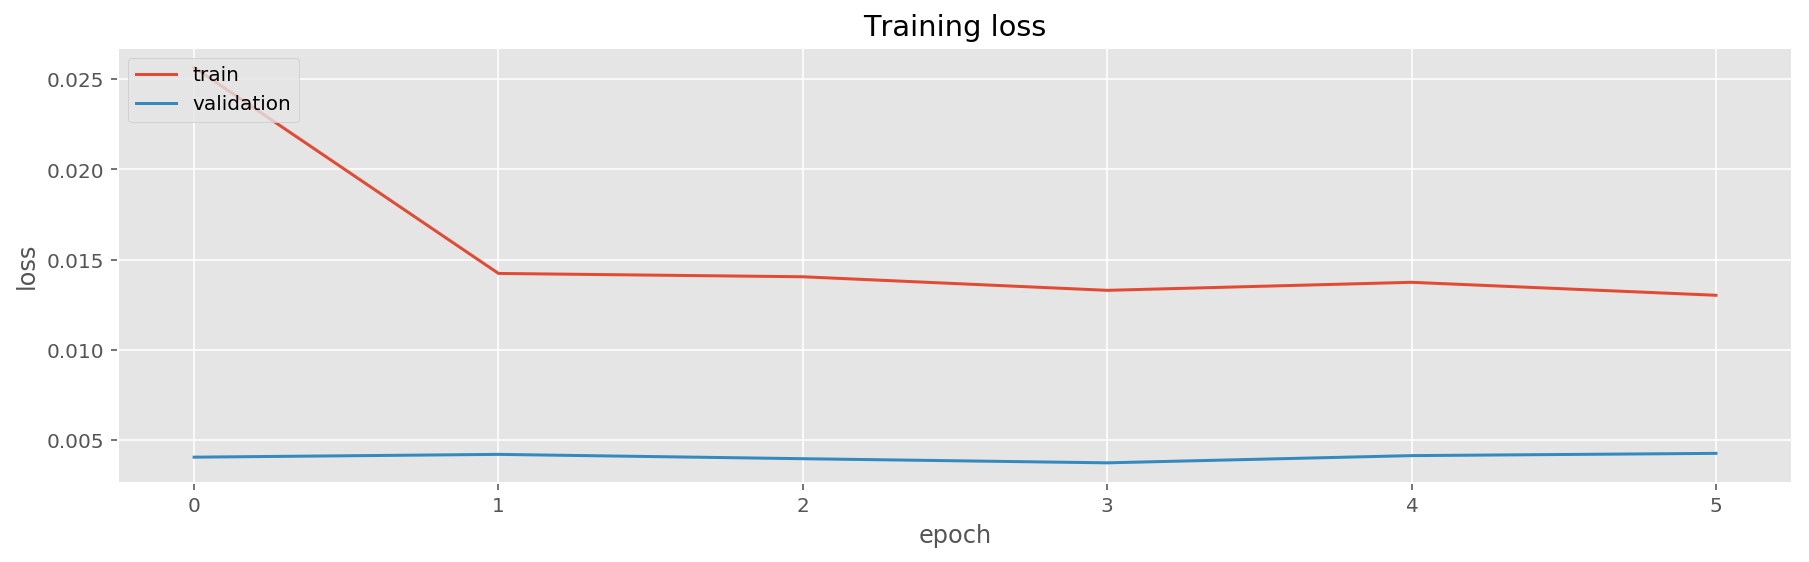

In [26]:
rcParams['figure.figsize'] = 15, 4
plot_train_loss(history_streams)

In [27]:
preds6 = flow_test.predict(test_list)

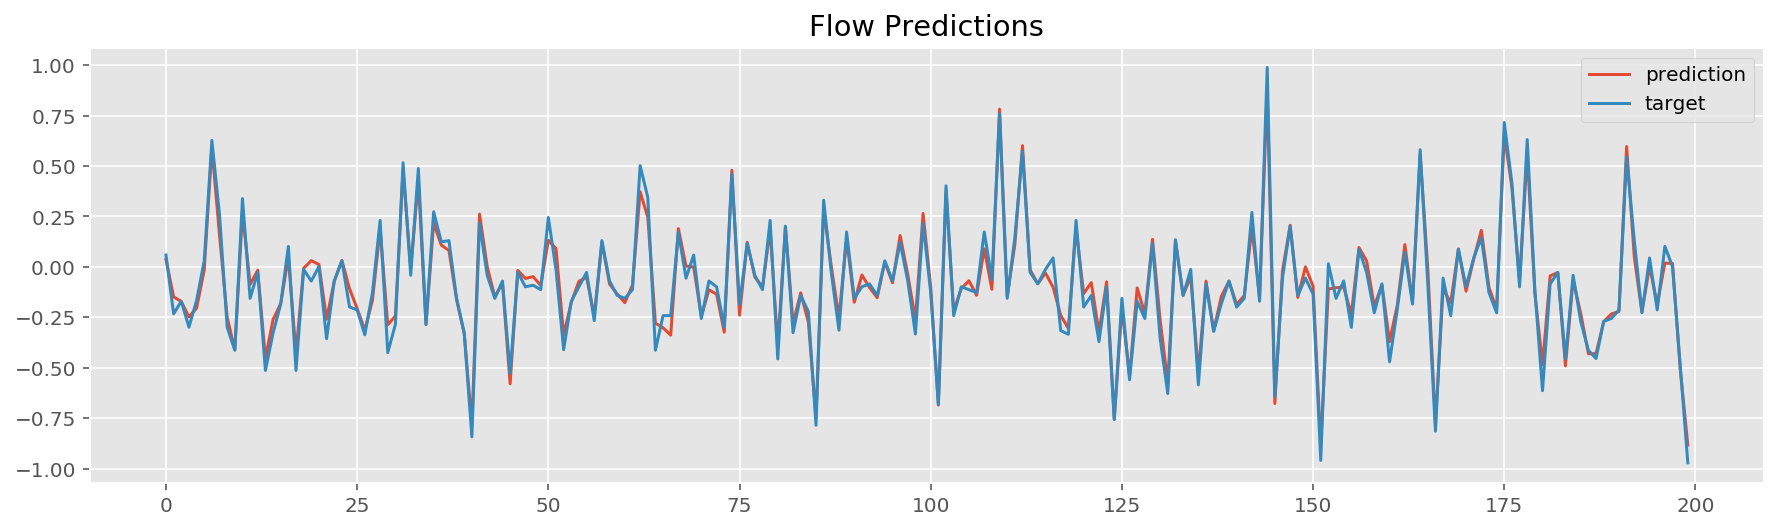

In [29]:
plt.plot(np.array(preds6[:200]).reshape(-1), label='prediction')
plt.plot(test_Y1[:200], label='target')
plt.title('Flow Predictions')
plt.legend()

### Experience 2:
        - Fine Tuning (training all layers)
        - Using embeddings

## Part 1C - Inception V3 pretrained on imagenet
    - Hay que usar la misma normalizacion, sino no funciona!

In [15]:
inception = inceptionV3()

In [21]:
# Training only the final layers for 5 epochs
inception_, history3 = train_convnet2D(inception, train_X_norm, 
                                           train_Y, val_X, val_Y, 
                                           model_name='inception_check.hdf5',
                                           epochs = 10)

In [78]:
inception_fine = finetune_V3(inception_)

In [79]:
# Fintetuning all layers
inception_final, history4 = train_convnet2D(inception_fine, train_X, 
                                           train_Y, val_X, val_Y, 
                                           model_name='inception_check.hdf5',
                                           epochs = 100)

Train on 75000 samples, validate on 14000 samples
Epoch 1/100
75000/75000 [==============================] - 625s 8ms/step - loss: 0.0721 - val_loss: 8.9180

Epoch 00001: val_loss improved from inf to 8.91804, saving model to inception_check.hdf5
Epoch 2/100
75000/75000 [==============================] - 619s 8ms/step - loss: 0.0701 - val_loss: 8.9753

Epoch 00002: val_loss did not improve from 8.91804
Epoch 3/100
75000/75000 [==============================] - 620s 8ms/step - loss: 0.0684 - val_loss: 8.8737

Epoch 00003: val_loss improved from 8.91804 to 8.87366, saving model to inception_check.hdf5
Epoch 4/100
75000/75000 [==============================] - 620s 8ms/step - loss: 0.0670 - val_loss: 8.8446

Epoch 00004: val_loss improved from 8.87366 to 8.84465, saving model to inception_check.hdf5
Epoch 5/100
75000/75000 [==============================] - 619s 8ms/step - loss: 0.0661 - val_loss: 8.7904

Epoch 00005: val_loss improved from 8.84465 to 8.79043, saving model to inception_ch

In [80]:
inception_final.evaluate(test_X, test_Y)

4053/4053 [==============================] - 26s 7ms/step


10.083221963561966

In [81]:
preds2 = [inception_final.predict(np.expand_dims(x, axis=0)) for x in test_X]

In [ ]:
plt.plot(np.array(preds2[:200]).reshape(-1), label='prediction')
plt.plot(test_Y[:200], label='target')
plt.title('Inception Imagenet Predictions')
plt.legend()

## Part 1CB - Inception V3 from scratch - Sin normalizar

In [10]:
inception = inceptionV3(imagenet=False)

In [15]:
# Training only the final layers for 5 epochs
inception_random, history3 = train_convnet2D(inception, train_X, 
                                           train_Y, val_X, val_Y, 
                                           model_name='inception_check.hdf5',
                                           epochs = 100)

Train on 75000 samples, validate on 14000 samples
Epoch 1/100
75000/75000 [==============================] - 522s 7ms/step - loss: 0.1109 - val_loss: 0.1220

Epoch 00001: val_loss improved from inf to 0.12201, saving model to inception_check.hdf5
Epoch 2/100
75000/75000 [==============================] - 491s 7ms/step - loss: 0.0959 - val_loss: 0.1230

Epoch 00002: val_loss did not improve from 0.12201
Epoch 3/100
75000/75000 [==============================] - 496s 7ms/step - loss: 0.0909 - val_loss: 0.1171

Epoch 00003: val_loss improved from 0.12201 to 0.11709, saving model to inception_check.hdf5
Epoch 4/100
75000/75000 [==============================] - 493s 7ms/step - loss: 0.0917 - val_loss: 0.1167

Epoch 00004: val_loss improved from 0.11709 to 0.11666, saving model to inception_check.hdf5
Epoch 5/100
75000/75000 [==============================] - 495s 7ms/step - loss: 0.0878 - val_loss: 0.1183

Epoch 00005: val_loss did not improve from 0.11666
Epoch 6/100
75000/75000 [========

In [17]:
inception_random.evaluate(test_X, test_Y)

4053/4053 [==============================] - 27s 7ms/step


0.11159098419309574

In [ ]:
preds4 = [inception_random.predict(np.expand_dims(x, axis=0)) for x in test_X]

In [ ]:
plt.plot(np.array(preds4[:200]).reshape(-1), label='prediction')
plt.plot(test_Y[:200], label='target')
plt.title('Inception Predictions')
plt.legend()